# 2.4.1 Regression Prediction

## 1. 간단한 예측 방법

### 호주 생산량 데이터 예측

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### 데이터 전처리

In [2]:
def parse_quarter_string(q):
    """
    Converts a quarter string 'YYYY Qq' to a datetime object.
    """
    year, quarter = q.split(' Q')
    first_month_of_quarter = 3 * int(quarter) - 2
    return f"{year}-{first_month_of_quarter}-01"

aus_production = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/aus_production.csv')
aus_production['Quarter'] = aus_production['Quarter'].apply(parse_quarter_string)
aus_production['Quarter'] = pd.to_datetime(aus_production['Quarter'])
aus_production.set_index('Quarter', inplace=True)

#### Naive forecasting

In [3]:
aus_production['Naive'] = aus_production['Bricks'].shift(1)

#### Naive seasonal forecasting

In [4]:
seasonality = 4
aus_production['Naive_Seasonal'] = aus_production['Bricks'].shift(seasonality)

#### Mean method

In [5]:
aus_production['Mean'] = aus_production['Bricks'].expanding().mean()

#### 예측

In [6]:
forecast_start = '2000-01-01'

naive_mask = (aus_production.index >= forecast_start)
naive_seasonal_mask = (aus_production.index >= forecast_start)
mean_mask = (aus_production.index >= forecast_start)

#### 시각화

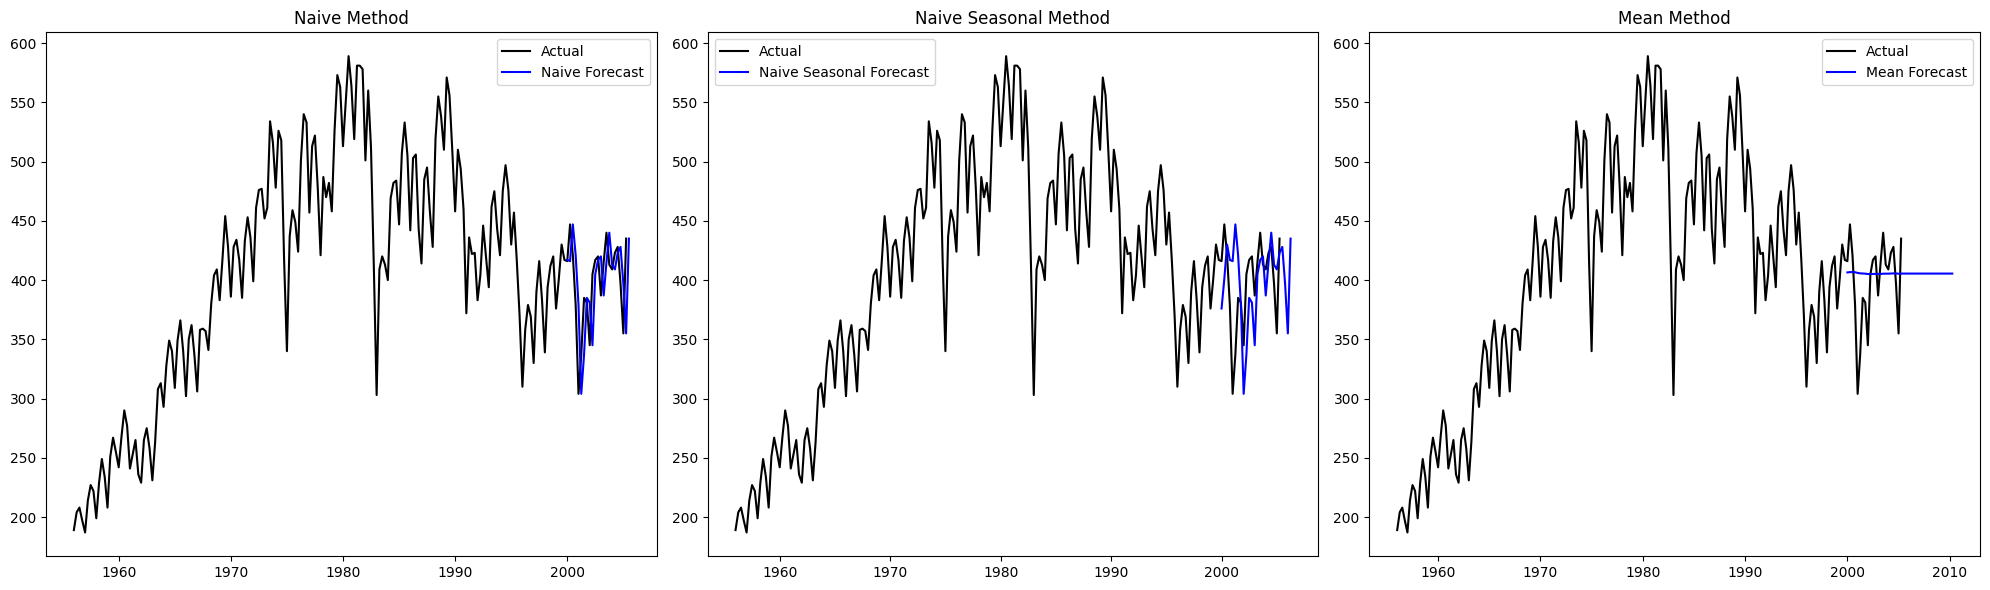

In [7]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(aus_production['Bricks'], label='Actual', color='black')
plt.plot(aus_production.index[naive_mask], aus_production['Naive'][naive_mask], label='Naive Forecast', color='blue')
plt.title('Naive Method')
plt.legend()

plt.subplot(132)
plt.plot(aus_production['Bricks'], label='Actual', color='black')
plt.plot(aus_production.index[naive_seasonal_mask], aus_production['Naive_Seasonal'][naive_seasonal_mask], label='Naive Seasonal Forecast', color='blue')
plt.title('Naive Seasonal Method')
plt.legend()

plt.subplot(133)
plt.plot(aus_production['Bricks'], label='Actual', color='black')
plt.plot(aus_production.index[mean_mask], aus_production['Mean'][mean_mask], label='Mean Forecast', color='blue')
plt.title('Mean Method')
plt.legend()

plt.tight_layout()
plt.show()

## 2. 선형회귀 예측

### 호주 생산량 데이터 선형 회귀

#### 필요한 패키지 불러오기

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#### 데이터 전처리

In [9]:
aus_production['Time_Index'] = np.arange(len(aus_production))

#### 선형회귀 모델

In [10]:
X = sm.add_constant(aus_production['Time_Index'])
y = aus_production['Bricks']

model = sm.OLS(y, X, missing='drop').fit()  

aus_production['Linear_Forecast'] = model.predict(X)

#### 시각화

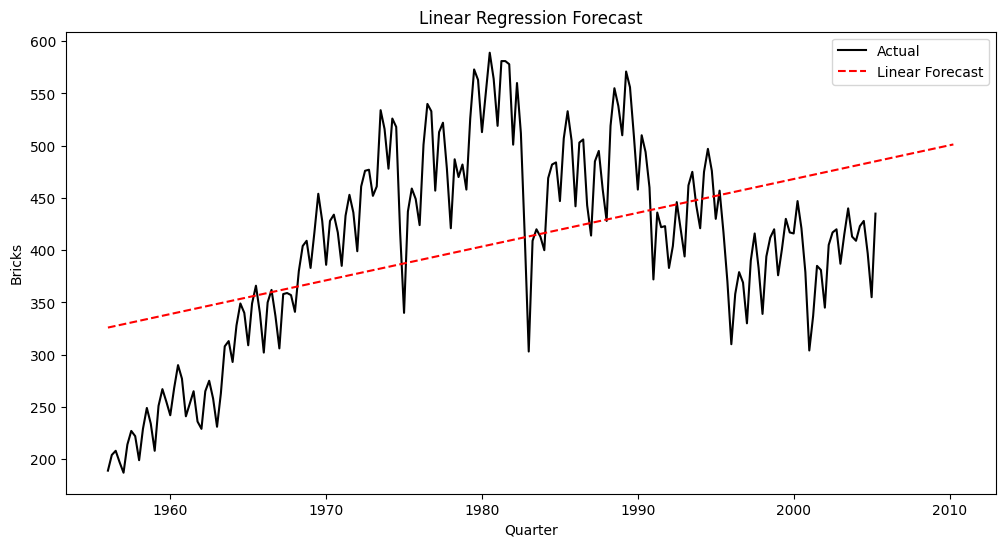

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(aus_production['Bricks'], label='Actual', color='black')
plt.plot(aus_production['Linear_Forecast'], label='Linear Forecast', color='red', linestyle='--')
plt.title('Linear Regression Forecast')
plt.xlabel('Quarter')
plt.ylabel('Bricks')
plt.legend()
plt.show()

## 부트스트랩 예측

### 구글 주가 데이터 부트스트랩

#### 데이터 전처리

In [56]:
import yfinance as yf

# 애플(AAPL) 주식 데이터 가져오기
ticker = "AAPL"
start_date = "2021-01-01"
end_date = "2022-12-31"

# 주식 데이터 다운로드
tick = yf.Ticker(ticker)
stock = tick.history(start=start_date, end=end_date)

# 2024년 종가 데이터 추출
stock = stock[['Close']]

In [60]:
stock['Naive_Forecast'] = stock['Close'].shift(1)
stock['Residuals'] = stock['Close'].diff(1)

#### 부트스트랩

In [63]:
np.random.seed(0)  
n_days = 100
n_simulations = 100  
last_value = stock['Close'].iloc[-1]

simulations = pd.DataFrame(index=range(n_days), columns=range(n_simulations))

for sim in range(n_simulations):
    simulated_values = [last_value]
    for day in range(1, n_days):
        simulated_values.append(simulated_values[day-1] + np.random.choice(stock['Residuals'].dropna()))
    simulations[sim] = simulated_values

percentiles = [80, 95]
lower_bounds = simulations.quantile(q=(1-percentiles[0]/100)/2, axis=1)
upper_bounds = simulations.quantile(q=1-(1-percentiles[0]/100)/2, axis=1)
lower_bounds_95 = simulations.quantile(q=(1-percentiles[1]/100)/2, axis=1)
upper_bounds_95 = simulations.quantile(q=1-(1-percentiles[1]/100)/2, axis=1)

#### 시각화

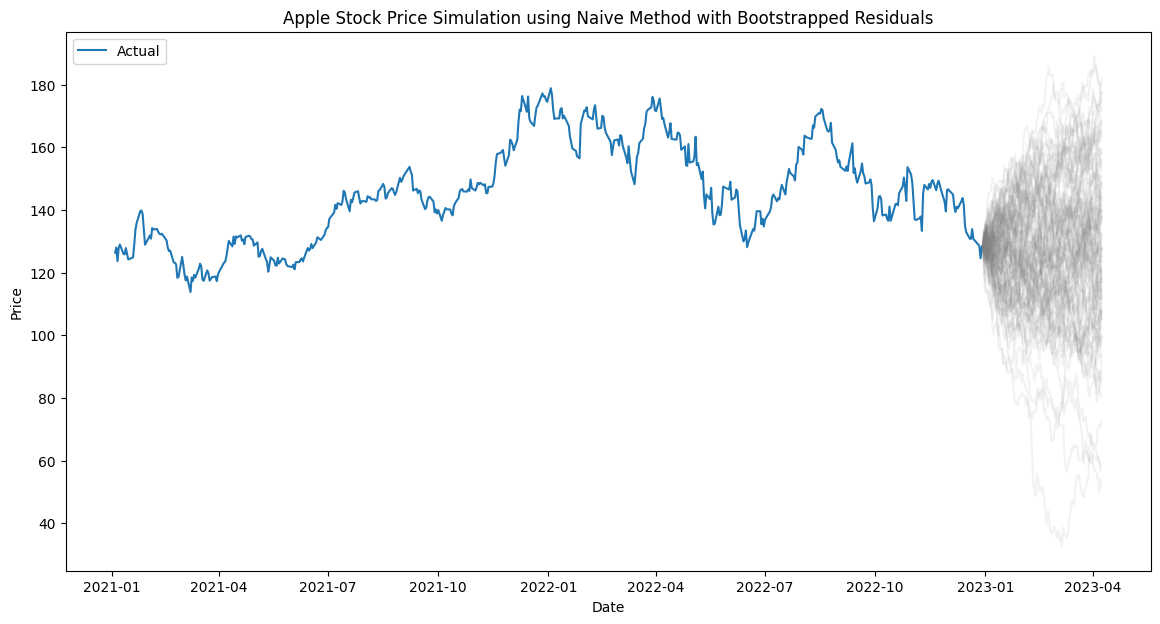

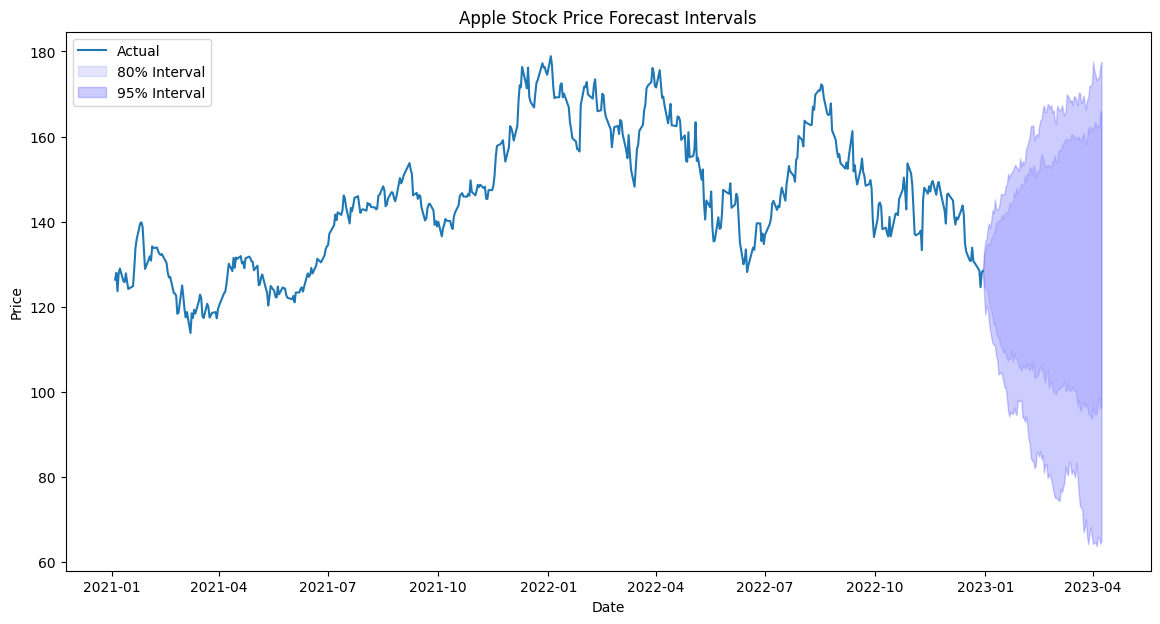

In [65]:
plt.figure(figsize=(14, 7))
plt.plot(stock.index, stock['Close'], label='Actual')
for sim in simulations.columns:
    plt.plot(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), simulations[sim], alpha=0.1, color='grey')
plt.title('Apple Stock Price Simulation using Naive Method with Bootstrapped Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(stock.index, stock['Close'], label='Actual')
plt.fill_between(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds, upper_bounds, color='blue', alpha=0.1, label=f'{percentiles[0]}% Interval')
plt.fill_between(stock.index[-1] + pd.to_timedelta(range(n_days), unit='D'), lower_bounds_95, upper_bounds_95, color='blue', alpha=0.2, label=f'{percentiles[1]}% Interval')
plt.title('Apple Stock Price Forecast Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2.4.2 Useful Features

## 2. 푸리에 회귀

### 호주 소매 판매량 데이터 푸리에 변환

#### 필요한 패키지 불러오기

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess 
from statsmodels.regression.linear_model import OLS

#### 데이터 전처리

In [16]:
aus_retail = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/aus_retail.csv")
aus_retail['Month'] = pd.to_datetime(aus_retail['Month'], format='%Y %m')
comparison_date = pd.to_datetime('1996-12-12')
aus_cafe = aus_retail[(aus_retail['Industry'] == "Cafes, restaurants and catering services")&(aus_retail['Month']<= comparison_date)].copy()
aus_cafe = aus_cafe.groupby('Month')['Turnover'].sum().reset_index()
aus_cafe.set_index('Month', inplace=True)
aus_cafe.sort_index(inplace=True)
if aus_cafe.index.duplicated().any():
    raise ValueError("Index still contains duplicates after grouping")
    
aus_cafe = aus_cafe.asfreq('MS')
print(aus_cafe.head())

            Turnover
Month               
1982-04-01     145.5
1982-05-01     144.1
1982-06-01     139.3
1982-07-01     145.7
1982-08-01     137.9


#### 푸리에 변환

In [17]:
def fit_fourier_series(df, K):
    df['Trend'] = np.arange(len(df))
    
    fourier_terms = CalendarFourier(freq='M', order=K)
    dp = DeterministicProcess(index=df.index, constant=True, additional_terms=[fourier_terms])
    X = dp.in_sample()
    
    X['Trend'] = np.arange(len(df))
    y = np.log(df['Turnover'])
    model = OLS(y, X).fit()
    
    df['fitted'] = np.exp(model.predict(X))
    future_dates = pd.date_range(df.index[-1], periods=48)
    X_forecast = dp.out_of_sample(steps=48, forecast_index=future_dates)
    X_forecast['Trend'] = np.arange(len(df), len(df) + 48)
    forecast = np.exp(model.predict(X_forecast))
    
    return df, forecast, future_dates

#### 시각화

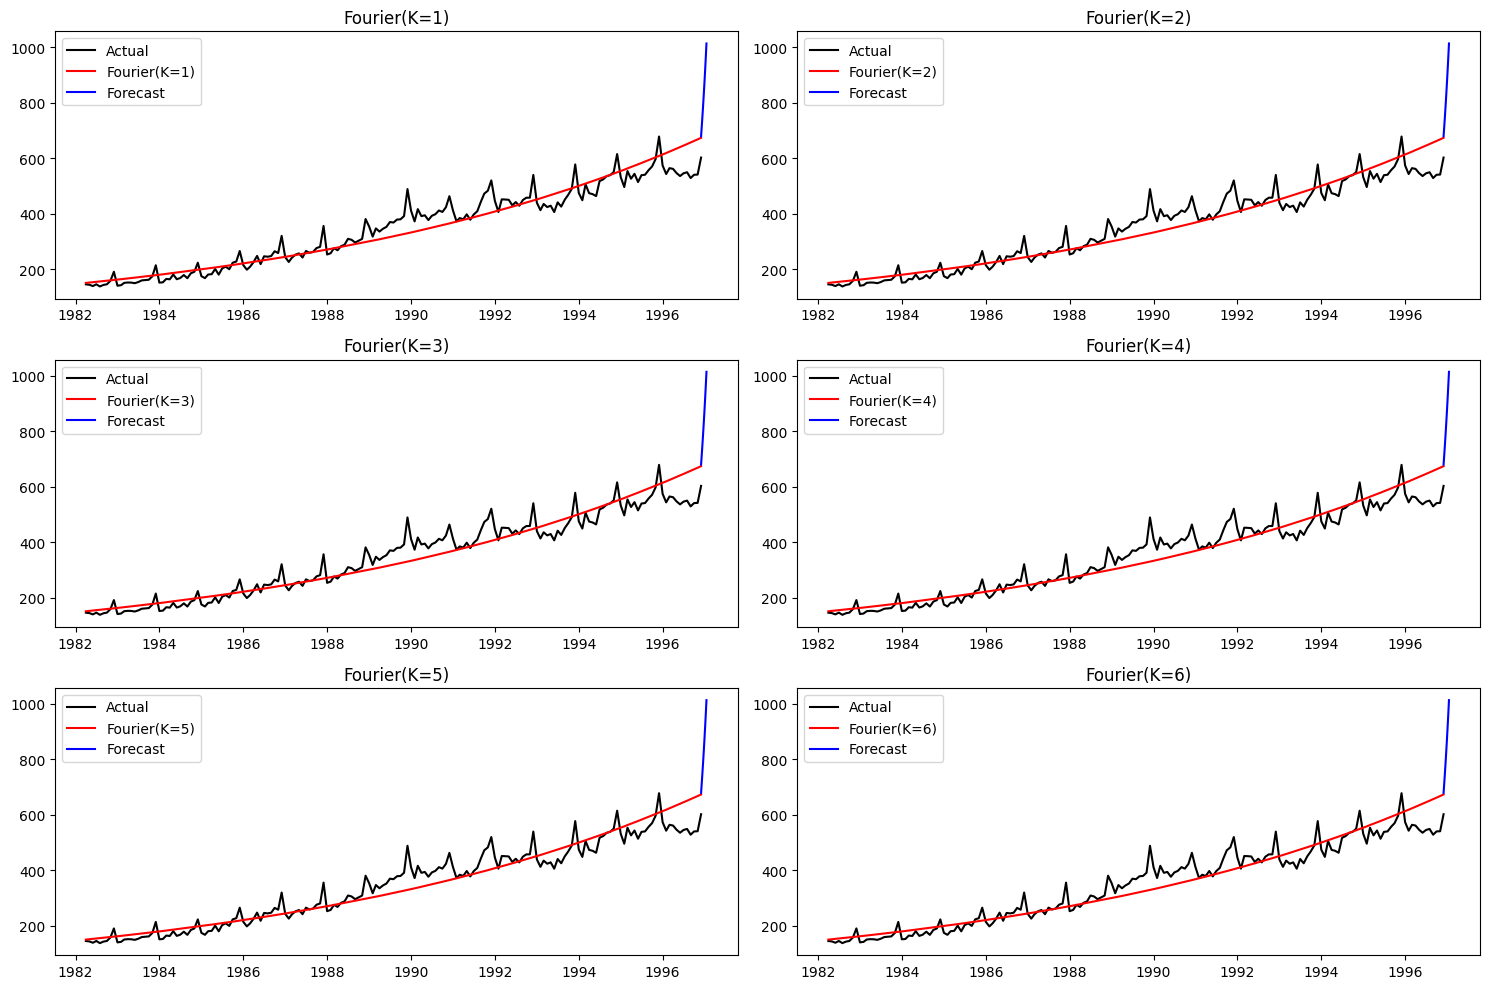

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()

for i, K in enumerate(range(1, 7)):  # K values from 1 to 6
    aus_cafe, forecast, future_dates = fit_fourier_series(aus_cafe.copy(), K)
    ax = axes[i]
    ax.plot(aus_cafe.index, aus_cafe['Turnover'], label='Actual', color='black')
    ax.plot(aus_cafe.index, aus_cafe['fitted'], label=f'Fourier(K={K})', color='red')
    ax.plot(future_dates, forecast, label='Forecast', color='blue')
    ax.set_title(f'Fourier(K={K})')
    ax.legend()

plt.tight_layout()
plt.show()

# 2.4.3 Trend features

### 소매 판매 데이터 결정론적 추세 모델링

#### 필요한 패키지 불러오기

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

#### 데이터 전처리

In [20]:
retail = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/example_retail_sales.csv")  
retail['ds'] = pd.to_datetime(retail['ds'])

start_date = retail['ds'].min()
retail['Time'] = (retail['ds'] - start_date) / np.timedelta64(1, 'm')

#### 모델 피팅

In [21]:
y = np.log(retail['y'])
X = add_constant(retail['Time'])
model = OLS(y, X).fit()

#### 추세 예측

In [22]:
retail['Fitted'] = model.predict(X)
retail['Exp_Fitted'] = np.exp(retail['Fitted'])

#### 시각화

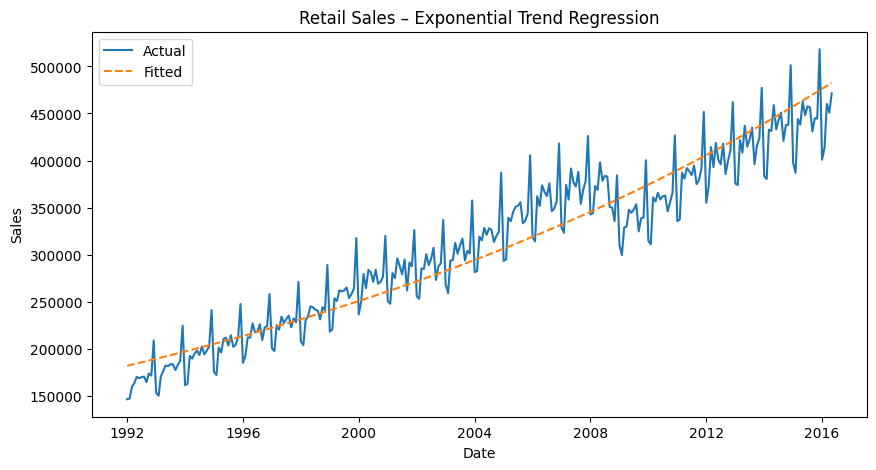

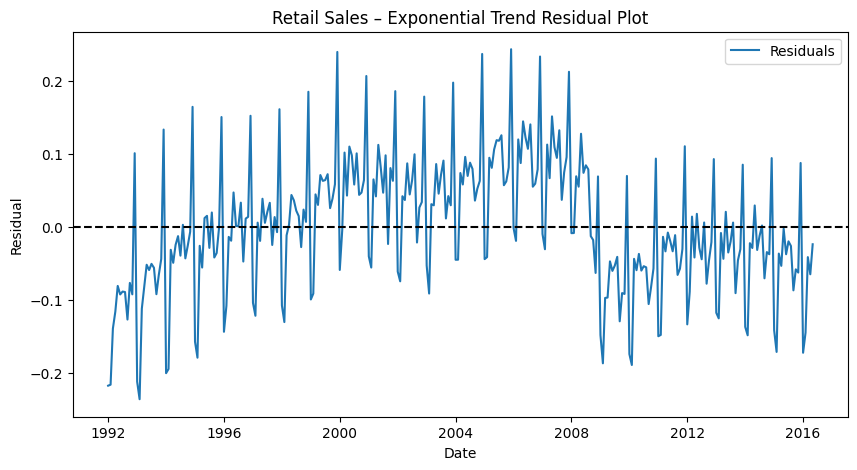

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(retail['ds'], retail['y'], label='Actual')
plt.plot(retail['ds'], retail['Exp_Fitted'], label='Fitted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Retail Sales – Exponential Trend Regression')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
residuals = y - retail['Fitted']
plt.plot(retail['ds'], residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Retail Sales – Exponential Trend Residual Plot')
plt.legend()
plt.show()

# 2.4.4 Seasonal features

### 호주 맥주 판매량 데이터 결정론적 계절성 모델링

#### 필요한 패키지 불러오기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates

#### 데이터 불러오기

In [25]:
aus_beer = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/aus_production.csv', parse_dates=['Quarter'], index_col='Quarter')

#### 시계열 분해

In [26]:
decomposition = seasonal_decompose(aus_beer['Beer'], model='additive', period=4)

#### 시각화

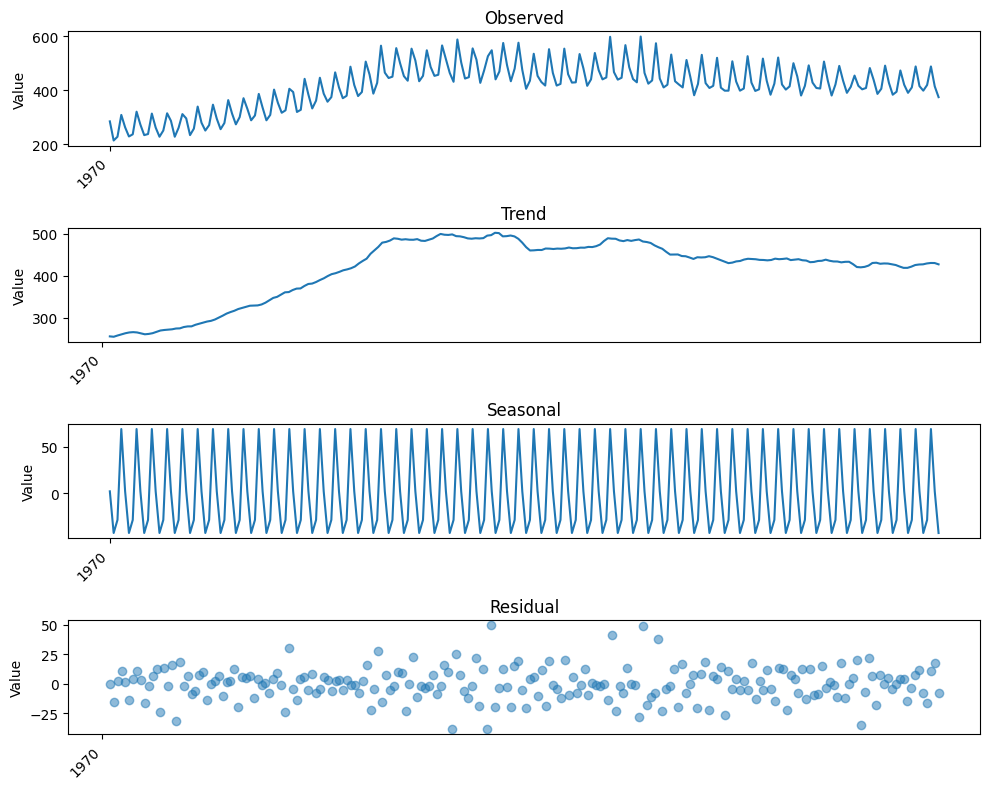

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(10, 8))

ax[0].plot(decomposition.observed)
ax[0].set_title('Observed', fontsize=12)
ax[0].set_ylabel('Value')

ax[1].plot(decomposition.trend)
ax[1].set_title('Trend', fontsize=12)
ax[1].set_ylabel('Value')

ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal', fontsize=12)
ax[2].set_ylabel('Value')

ax[3].scatter(aus_beer.index, decomposition.resid, alpha=0.5)
ax[3].set_title('Residual', fontsize=12)
ax[3].set_ylabel('Value')

ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[2].xaxis.set_major_locator(mdates.YearLocator())
ax[3].xaxis.set_major_locator(mdates.YearLocator())

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for axis in ax:
    plt.setp(axis.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### 모델 피팅

In [28]:
sarima_model = SARIMAX(aus_beer['Beer'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
sarima_results = sarima_model.fit()
residuals = sarima_results.resid

#### 시각화

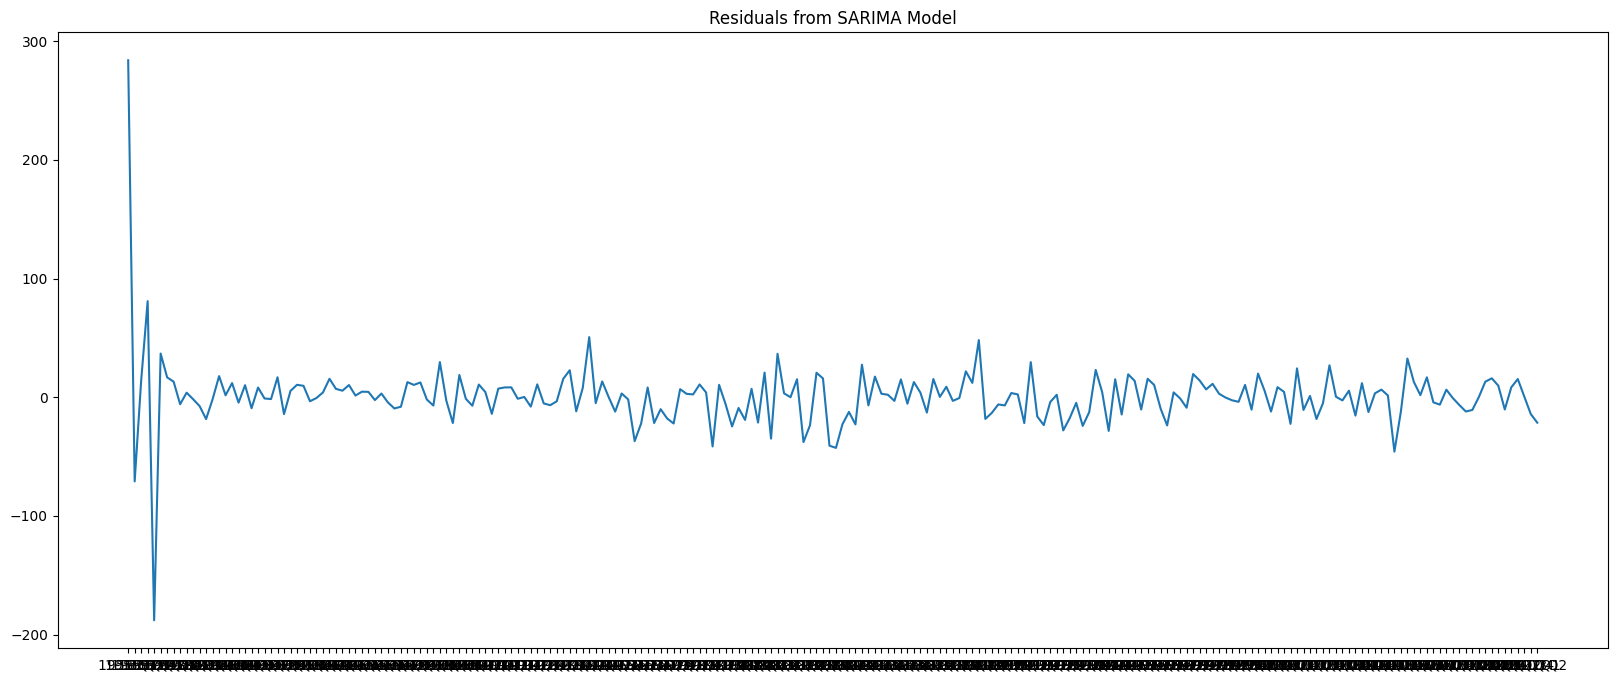

<Figure size 2000x800 with 0 Axes>

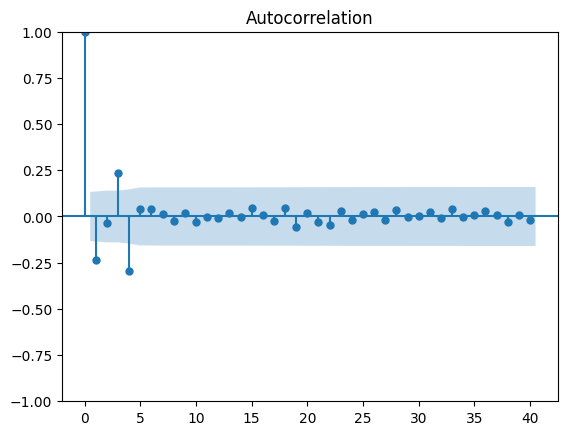

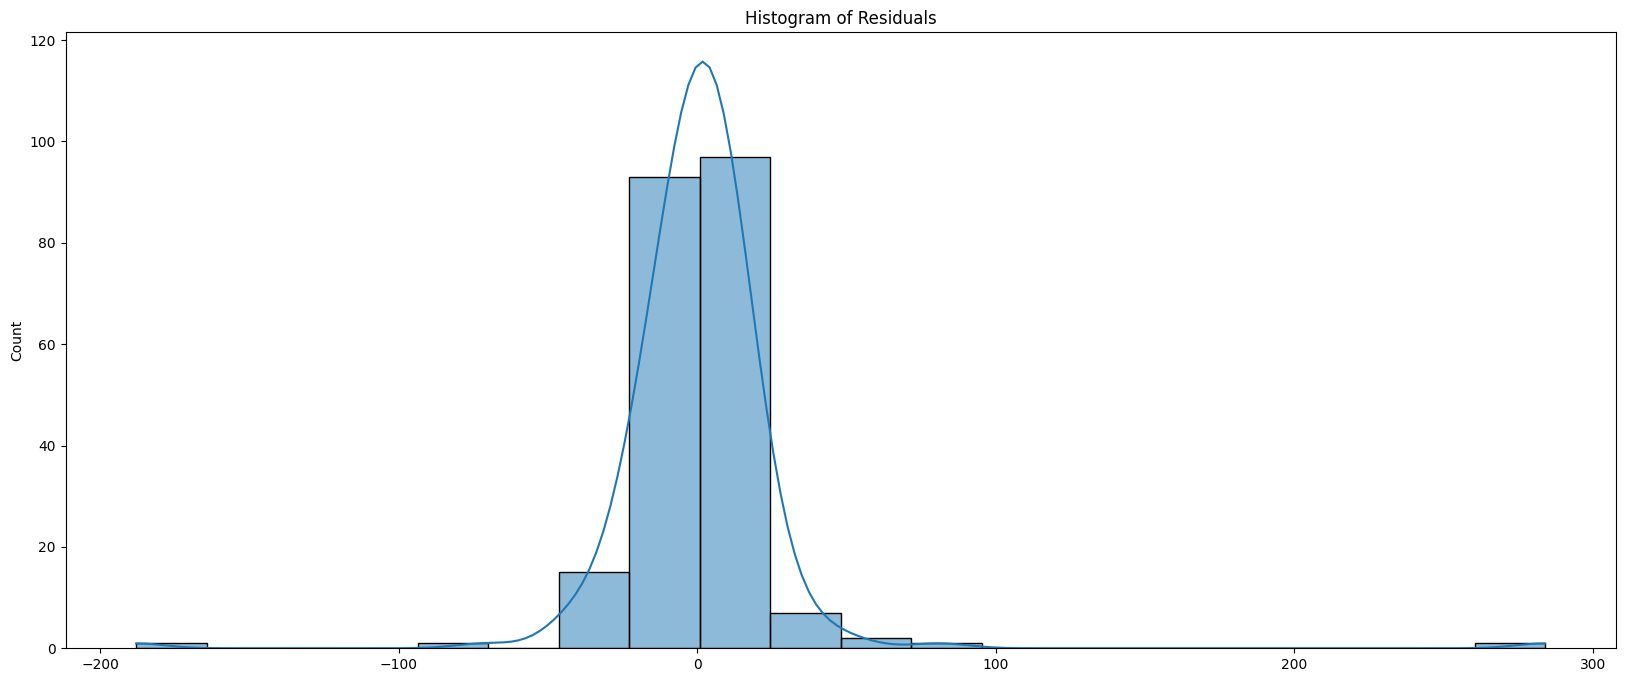

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model')
plt.show()

plt.figure(figsize=(20, 8))
plot_acf(residuals, lags=40)
plt.show()

plt.figure(figsize=(20, 8))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Histogram of Residuals')
plt.show()

#### 모델 시각화

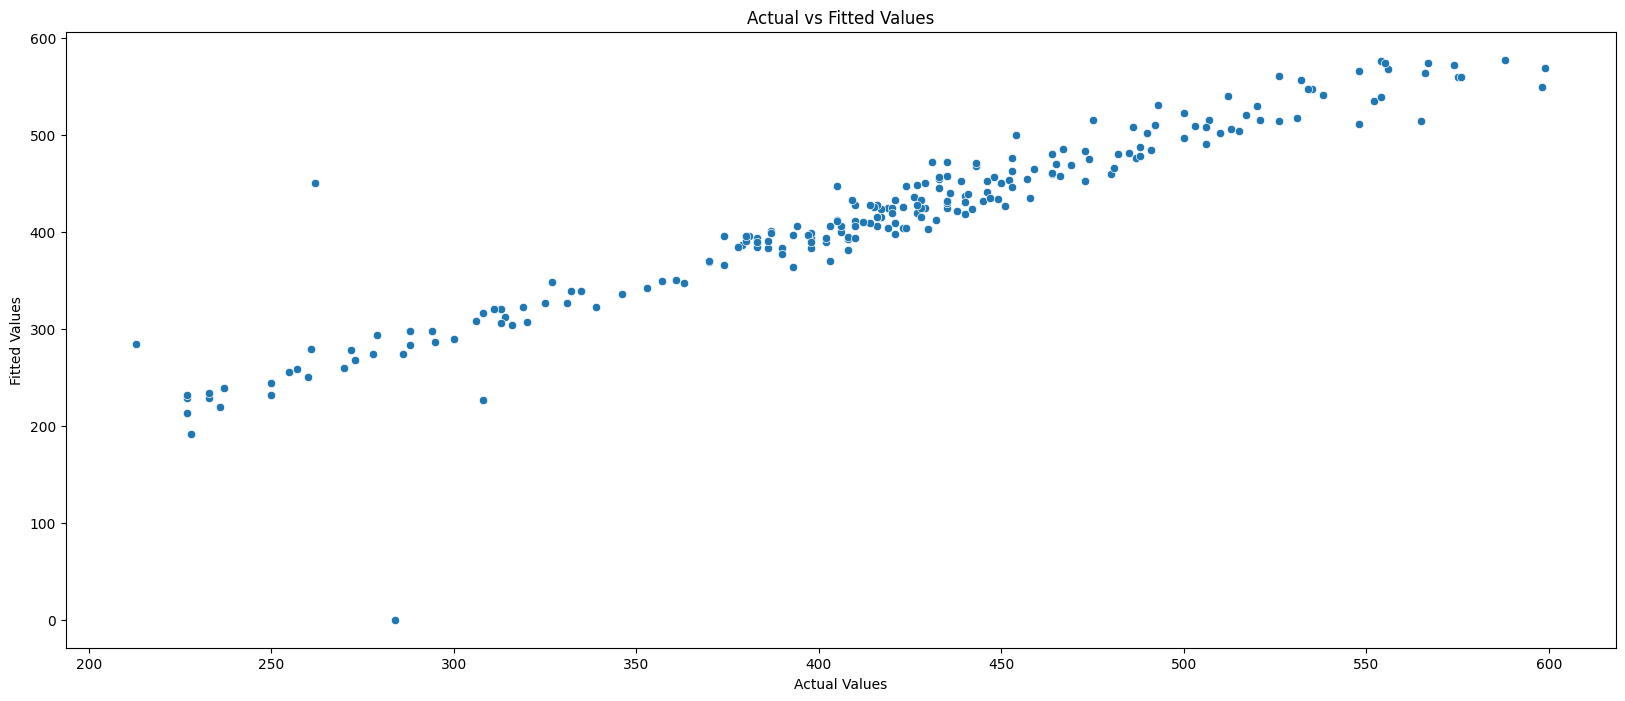

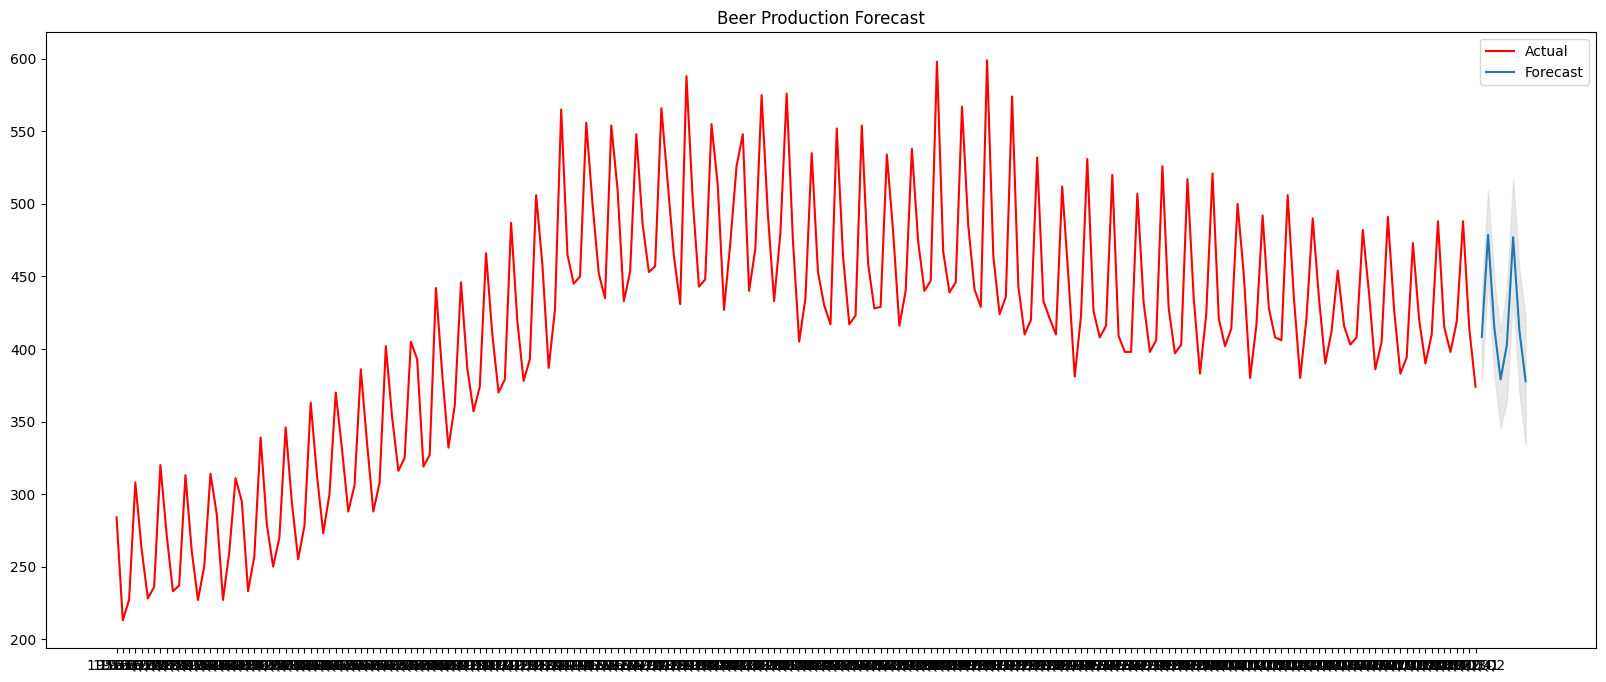

In [30]:
fitted_values = sarima_results.fittedvalues
plt.figure(figsize=(20, 8))
sns.scatterplot(x=aus_beer['Beer'], y=fitted_values)
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.title('Actual vs Fitted Values')
plt.show()

forecast = sarima_results.get_forecast(steps=8)
forecast_ci = forecast.conf_int()
plt.figure(figsize=(20, 8))
plt.plot(aus_beer.index, aus_beer['Beer'], label='Actual', color = 'red')
plt.plot(forecast_ci.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightgrey', alpha=0.5)
plt.title('Beer Production Forecast')
plt.legend()
plt.show()